Generate the sky coverage plot of the ALFABURST survey from system logs, used in ALFABURST Survey 2017 manuscript.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units
from astropy.coordinates import SkyCoord
import healpy as hp
import pandas as pd

%matplotlib inline

In [2]:
cognizePkl = '../data/cognize.pkl'

In [3]:
df = pd.read_pickle(cognizePkl)
activeObs = df[df.status==1] # select log of active observations

# NOTE:only using the central beam
# RA in hours, DEC in degrees and flipped
ra0 = activeObs['RA0'].values * (15. * np.pi / 180.) # Hours to radians
dec0 = (activeObs['DEC0'].values * (np.pi / 180.) ) # Degrees to radians
tint = activeObs['tint'].values # integration time in seconds

tintSec = np.sum(tint)

print 'Total observation time: %f hours (%i seconds)'%(tintSec/3600., tintSec)

Total observation time: 1064.066667 hours (3830640 seconds)


In [4]:
nside = 128 # NOTE: nside=256, this is the approxomate sky coverage of the ALFA FWHM of the 7 combined beams
# Convert (RA, Dec) to Galactic (lat, long)
coords = SkyCoord(ra=ra0 * astropy.units.rad, dec=dec0 * astropy.units.rad, frame='icrs')

hpMap = np.zeros(hp.nside2npix(nside))
hpMask = np.zeros(hp.nside2npix(nside))

gall = coords.galactic.l.degree
galb = coords.galactic.b.degree

In [5]:
# Bin galactic coordinates to healpix pixels
for pid in np.arange(gall.shape[0]): # NOTE: dumb and slow, but the call to hp.ang2pix() with dec/ra arrays doesn't seem to work
    pixVal = hp.ang2pix(nside, gall[pid], galb[pid], lonlat=True)
    hpMap[pixVal] += tint[pid]
    hpMask[pixVal] = True

In [6]:
# Clip max values
#maxClip = 100.
#print 'Max integration time %f clipped to %f'%(hpMap.max(), maxClip)
#hpMap = np.clip(hpMap, 0., maxClip)

hpMap += 1

In [7]:
# Coordinate Projection
coordProj = 'G'
if coordProj == 'C':
    coord = 'GC'
    gradCoord = 'C'
else:
    coord = 'G'
    gradCoord = 'G'

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


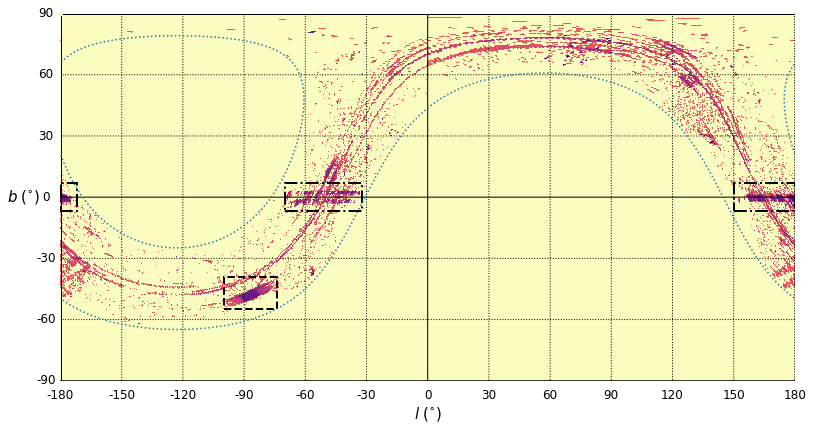

In [8]:
import matplotlib.patches as patches

cmap = 'magma_r'
fig = plt.figure(figsize=(12,6.5)) # (width, height)

hp.cartview(hpMap, fig=fig.number, coord=coord, cmap=plt.get_cmap(cmap), unit='seconds', \
            title='', norm='log', cbar=False, notext=True)
#            title='Sky Coverage (July 2015 - June 2017)', norm='log', cbar=False, notext=True)

hp.graticule(coord=gradCoord)

hp.projplot(np.linspace(-180., 180., 512), np.ones(512) * 38., lonlat=True, coord='C', linestyle=':') # DEC +36 pointing limit
hp.projplot(np.linspace(-180., 180., 512), np.ones(512) * -2., lonlat=True, coord='C', linestyle=':') # Dec 0 pointing limit

ax = fig.axes[0]

# PALFA and AGES regions
for patch in [
    #patches.Rectangle( (-180., -7.), 8., 14., fill=True, alpha=0.2, linestyle='dashdot', facecolor='blue'),
    #patches.Rectangle( (-70., -7.), 38., 14., fill=True, alpha=0.2, linestyle='dashdot', facecolor='blue'),
    #patches.Rectangle( (150., -7.), 30., 14., fill=True, alpha=0.2, linestyle='dashdot', facecolor='blue'),
    #patches.Rectangle( (-98., -55.), 24., 16., fill=True, alpha=0.2, linestyle='dotted', facecolor='red'),
    patches.Rectangle( (-180., -7.), 8., 14., fill=False, linestyle='dashdot', lw=2),
    patches.Rectangle( (-70., -7.), 38., 14., fill=False, linestyle='dashdot', lw=2),
    patches.Rectangle( (150., -7.), 30., 14., fill=False, linestyle='dashdot', lw=2),
    patches.Rectangle( (-100., -55.), 26., 16., fill=False, linestyle='dashed', lw=2),
]:
    ax.add_patch(patch)

ax.text(0.5, -0.09, '$l \;(^{\circ})$', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center', \
        fontsize=15)
ax.text(-0.05, 0.5, '$b \; (^{\circ})$', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center', \
        fontsize=15)

for bVal in np.linspace(-90, 90, 7, endpoint=True):
    ax.text(-0.02, 0.5 + bVal/180., '%0.f'%(bVal), transform=ax.transAxes, horizontalalignment='center', \
            verticalalignment='center', fontsize=12)

for lVal in np.linspace(-180, 180, 13, endpoint=True):
    ax.text(lVal/360. + 0.5, -0.04, '%0.f'%(lVal), transform=ax.transAxes, horizontalalignment='center', \
            verticalalignment='center', fontsize=12)

plt.savefig('../figures/cartview_sky_coverage.pdf')